In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
from math import log, sqrt, exp
from scipy import integrate

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import brentq, least_squares, curve_fit
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

# Part1

##### Question 1

In [2]:
df_ois = pd.read_excel('IR Data.xlsx', sheet_name = 'OIS')
df_ois = df_ois.drop(columns = ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])

In [3]:
df_ois['Tenor'][0] = 0.5

for i in range(1,len(df_ois)):
    df_ois['Tenor'][i] = float(df_ois['Tenor'][i].rstrip('y'))

In [4]:
df_ois['f_o'] = np.nan
df_ois['D_o'] = np.nan
df_ois['f_o'][0] = ((((1+(0.5*df_ois['Rate'][0]))**(1/(df_ois['Tenor'][0]*360)))-1)*360)
df_ois['D_o'][0] = (1/(1+(df_ois['f_o'][0]/360)))**(df_ois['Tenor'][0]*360)
df_ois['f_o'][1] = ((((1+df_ois['Rate'][1])/((1+df_ois['f_o'][0]/360)**(180)))**(1/180))-1)*360
df_ois['D_o'][1] = ((1/(1+(df_ois['f_o'][0]/360)))**(180))*((1/(1+(df_ois['f_o'][1]/360)))**180)

# we note that the previous df_com['f_o'][1] is the forward rate D_o(6m,1y)
# hence we replace it with the tenor discount rate D_0(0,1y)
df_ois['f_o'][1] = (((1+df_ois['f_o'][0])*(1+df_ois['f_o'][1]))**0.5)-1

In [5]:
t = pd.DataFrame(np.arange(1.0, 31.0, 1.0),columns = ['Tenor'])

df_ois = pd.merge(t,
                  df_ois,
                  on = 'Tenor', 
                  how = 'outer'
                  ).sort_values(by = 'Tenor').reset_index(drop=True)

In [6]:
def ois_solver(x): 
    # unknown discount factor mathematically reduced to the following:
    flt_x = df_ois['D_o'][i-1] - x 
    fix_dis_x = 0
    for n in range(0,h-i+1):
        # linear interpolation on OIS discount factor
        D = x + ((h-i-n)/(h-i+1))*flt_x
        fix_dis_x += D
    fix_x = fix_dis_x * df_ois['Rate'][h]
    return fix_x + fix - flt_x - flt

In [7]:
i = 2
while i <= 30:
    h = i
    while np.isnan(df_ois['Rate'][h]):
        h += 1
    k =1
    fix = 0
    while k < i:
        fix_i = df_ois['D_o'][k]*df_ois['Rate'][h]
        fix += fix_i
        k+=1
    flt = df_ois['Rate'][i-1]*df_ois['D_o'][1:i].sum()
    f = lambda x:(ois_solver(x))
    # use brentq to solve the equation
    D_l = brentq(f, 0, 1)
    for n in range(0,h-i+1):
        df_ois['D_o'][i+n] = D_l + ((h-i-n)/(h-i+1))*(df_ois['D_o'][i-1] - D_l)
        df_ois['f_o'][i+n] = 360*((df_ois['D_o'][i+n-1]/df_ois['D_o'][i+n])**(1/360)-1)
    i = h+1

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

<AxesSubplot: title={'center': 'OIS Discount Factor vs. Tenor'}, xlabel='Tenor (years)', ylabel='OIS Discount Factor'>

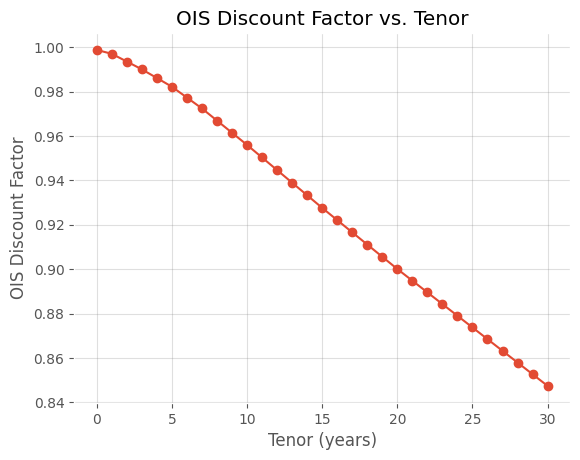

In [9]:
df_ois['D_o'].plot(marker = 'o',
                   title = 'OIS Discount Factor vs. Tenor',
                   xlabel = 'Tenor (years)',
                   ylabel = 'OIS Discount Factor')

###### Question 2

In [10]:
df_irs = pd.read_excel('IR Data.xlsx', sheet_name = 'IRS')
df_irs = df_irs.drop(columns = ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])

In [11]:
df_irs['Tenor'][0] = 0.5
for i in range(1,11):
    df_irs['Tenor'][i] = float(df_irs['Tenor'][i].rstrip('y'))

df_irs

,Tenor,Product,Rate
0,0.5,LIBOR,0.0250
1,1.0,IRS,0.0280
2,2.0,IRS,0.0300
3,3.0,IRS,0.0315
4,4.0,IRS,0.0325
5,5.0,IRS,0.0330
6,7.0,IRS,0.0350
7,10.0,IRS,0.0370
8,15.0,IRS,0.0400
9,20.0,IRS,0.0450


In [12]:
t2 = pd.DataFrame(np.arange(0.5, 30.5, 0.5), columns = ['Tenor'])
df_irs = pd.merge(t2,df_irs, on='Tenor', how='left')
df_irs = df_irs.drop('Product', axis = 1).rename(columns = {'Rate':'irs_rate'})

In [13]:
df = pd.merge(df_ois, df_irs, on='Tenor', how='outer')
df.columns = [x.lower() for x in df.columns]

In [14]:
df = df.rename(columns = {'rate':'ois_rate'})\
                          .drop('product', axis=1)\
                          .sort_values(by = 'tenor')\
                          .reset_index(drop = True)

In [15]:
df['f_l'] = np.nan
df['d_l'] = np.nan
df['f_l'][0]=df['irs_rate'][0]
df['d_l'][0]= 1/(1+0.5*df['irs_rate'][0])
df['f_l'][1] = (df['irs_rate'][1] * (df['d_o'][0]+df['d_o'][1]) - (df['f_l'][0] * df["d_o"][0]))/df["d_o"][1]
df['d_l'][1] = (1 / (1 + 0.5 * df['f_l'][0])*(1 / (1 + 0.5* df['f_l'][1])))

In [16]:
df['d_o'].interpolate(method='linear',inplace=True)

In [17]:
def libor_solver(x):
    diff = df['d_l'][i-2] - x
    Ds = [df['d_l'][i-2]]
    Ls = []
    for n in range(0,h-i+2):
        D = x + ((h-i-n+1)/(h-i+2))*diff
        L = 0.5*(2*(Ds[-1]-D)/D)*df['d_o'][i-1+n]
        Ds.append(D)
        Ls.append(L)
    flt_x = sum(Ls)
    return flt_x + flt - fix

In [18]:
i = 3
while i <= 60:
    h = i
    while np.isnan(df['irs_rate'][h]):
        h += 2
    fix = 0.5*df['irs_rate'][h]*df['d_o'][0:h+1].sum()
    flt = 0
    k = 0
    while k <= i-2:
        flt_i = 0.5*df['d_o'][k]*df['f_l'][k]
        flt += flt_i
        k += 1
    f = lambda x:(libor_solver(x))
    D_l =  brentq(f, 0, 1)
    for n in range(0,h-i+2):
        df['d_l'][i-1+n] = D_l + ((h-i-n+1)/(h-i+2))*(df['d_l'][i-2] - D_l)
        df['f_l'][i-1+n] = (df['d_l'][i-2+n]-df['d_l'][i-1+n])/(0.5*df['d_l'][i-1+n])
    i = h+2

In [19]:
df.set_index('tenor', inplace = True)

In [20]:
df

,ois_rate,f_o,d_o,irs_rate,f_l,d_l
tenor,,,,,,
0.5,0.00250,0.002498,0.998752,0.0250,0.025000,0.987654
1.0,0.00300,0.002995,0.997009,0.0280,0.031005,0.972577
1.5,NaN,NaN,0.995270,NaN,0.031751,0.957378
2.0,0.00325,0.003495,0.993531,0.0300,0.032263,0.942179
2.5,NaN,NaN,0.991773,NaN,0.034218,0.926330
3.0,0.00335,0.003545,0.990015,0.0315,0.034814,0.910482
3.5,NaN,NaN,0.988066,NaN,0.035207,0.894731
4.0,0.00350,0.003946,0.986117,0.0325,0.035838,0.878981
4.5,NaN,NaN,0.984150,NaN,0.034713,0.863985


<AxesSubplot: title={'center': 'LIBOR Discount Factor vs. Tenor'}, xlabel='Tenor (years)', ylabel='LIBOR Discount Factor'>

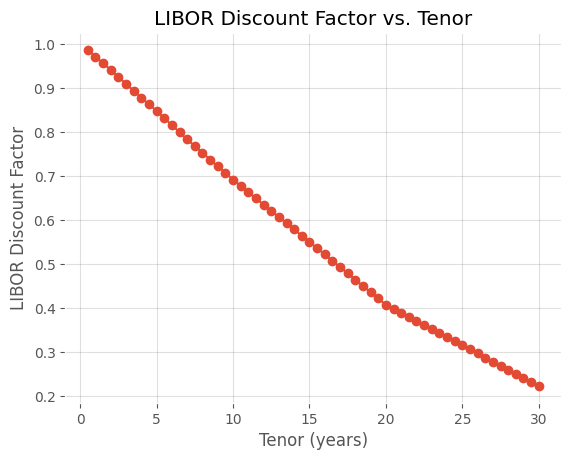

In [21]:
df['d_l'].plot(marker = 'o',
               title = 'LIBOR Discount Factor vs. Tenor',
               xlabel = 'Tenor (years)',
               ylabel = 'LIBOR Discount Factor')

##### Question 3

In [22]:
df_psr = df.reset_index()

In [23]:
df_psr

,tenor,ois_rate,f_o,d_o,irs_rate,f_l,d_l
0,0.5,0.00250,0.002498,0.998752,0.0250,0.025000,0.987654
1,1.0,0.00300,0.002995,0.997009,0.0280,0.031005,0.972577
2,1.5,NaN,NaN,0.995270,NaN,0.031751,0.957378
3,2.0,0.00325,0.003495,0.993531,0.0300,0.032263,0.942179
4,2.5,NaN,NaN,0.991773,NaN,0.034218,0.926330
5,3.0,0.00335,0.003545,0.990015,0.0315,0.034814,0.910482
6,3.5,NaN,NaN,0.988066,NaN,0.035207,0.894731
7,4.0,0.00350,0.003946,0.986117,0.0325,0.035838,0.878981
8,4.5,NaN,NaN,0.984150,NaN,0.034713,0.863985
9,5.0,0.00360,0.003996,0.982184,0.0330,0.035326,0.848989


In [24]:
def psr(exp,t):
    m = exp + t
    exp_i = exp*2
    m_i = m*2-1
    flt = 0
    fix = 0
    while exp_i <= m_i:
        flt_i = df_psr['f_l'][exp_i]*0.5*df_psr['d_o'][exp_i] # float at each tenor
        flt += flt_i  
        fix_i = 0.5*df_psr['d_o'][exp_i] #fix at each tenor
        fix += fix_i
        exp_i += 1
    psr = flt/fix
    return psr

In [25]:
e = np.array([1]*5 + [5]*5 + [10]*5)
tn = np.array([1,2,3,5,10] * 3)

In [26]:
par_swap_rates = pd.DataFrame([], columns=['Expiry in year(s)','Tenor in year(s)', 'Par_Swap_Rate'])

In [27]:
par_swap_rates['Expiry in year(s)'] = e
par_swap_rates['Tenor in year(s)'] = tn

In [28]:
for u in np.arange(0,15,1):
    par_swap_rates['Par_Swap_Rate'][u] = psr(e[u],tn[u])

In [29]:
par_swap_rates

,Expiry in year(s),Tenor in year(s),Par_Swap_Rate
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [30]:
par_swap_rates.to_csv('forward_swap.csv')
df_psr.to_csv('oi_libor_disfactors.csv')